## Imports

In [406]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import GreekLettersCNN

## Import Data

In [402]:
path_to_training_data = './kaggle/train.csv'
path_to_test_data = './kaggle/test.csv'

df_train = pd.read_csv(path_to_training_data, header=None)
df_test = pd.read_csv(path_to_test_data, header=None)

X_train = torch.tensor(df_train.iloc[:, :-1].to_numpy().reshape(df_train.shape[0], 1, 14, 14), dtype=torch.float32)
Y_train = torch.tensor(df_train.iloc[:, -1].to_numpy() - 1, dtype=torch.long)
X_test = torch.tensor(df_test.iloc[:, :-1].to_numpy().reshape(df_test.shape[0], 1, 14, 14), dtype=torch.float32)
Y_test = torch.tensor(df_test.iloc[:, -1].to_numpy() - 1, dtype=torch.long)

print(f"The size of the training set is: {X_train.shape}")
print(f"The size of the test set is: {X_test.shape}")

The size of the training set is: torch.Size([240, 1, 14, 14])
The size of the test set is: torch.Size([96, 1, 14, 14])


In [441]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature, label = self.data[idx], self.labels[idx]
        if self.transform:
            feature = self.transform(feature)

        return (feature, label)
    
data_transform = v2.Compose([
    v2.RandomAffine(degrees=(-8, 8), translate=(0.1, 0.1), scale=(0.7, 1.1), fill=255),
    v2.RandomAdjustSharpness(p = 0.2, sharpness_factor=2)
])

custom_dataset = CustomDataset(data=X_train, labels=Y_train)

batch_size = 20
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

# Visualise

In [435]:
def show_data(data, res):
    rows, cols = data.shape[:2]
    x_res, y_res = res

    fig, ax = plt.subplots(int(np.ceil(rows/20)), 20, figsize=(12, 12))
    ax = ax.flatten()
    for i in range(rows):
        image = data[i].reshape(14, 14)
        ax[i].imshow(image, cmap='gray')
        ax[i].axis('off')
    fig.set_facecolor('black')
    plt.tight_layout()
    plt.show()

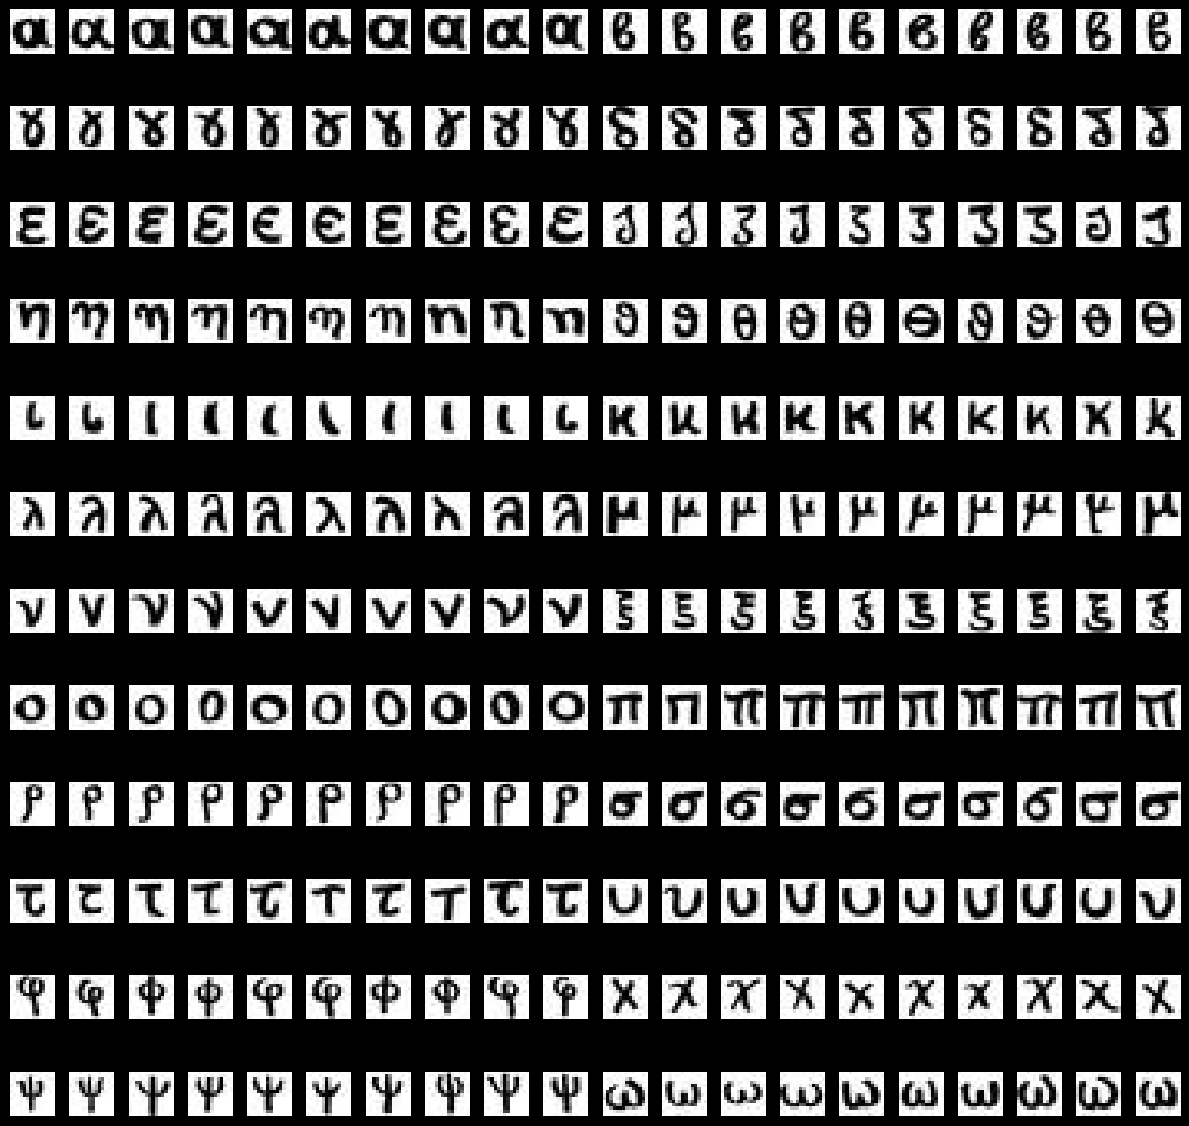

In [430]:
show_data(X_train, res=(14,14))

# Model Training

In [442]:
loss_fn = nn.CrossEntropyLoss()
model = GreekLettersCNN()
learning_rate = 3e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = []

Epoch: 0 Loss: 38.75280046463013
Epoch: 10 Loss: 0.7375861259642988
Epoch: 20 Loss: 0.0005962560253465199
Epoch: 30 Loss: 0.00039007731811580015
Epoch: 40 Loss: 0.00028186890790493635
Epoch: 50 Loss: 0.00020509258274614695
Epoch: 60 Loss: 0.00015836275383662723
Epoch: 70 Loss: 0.00018822562753939565
Epoch: 80 Loss: 0.00010221661341347499
Epoch: 90 Loss: 9.81079551820585e-05
Epoch: 100 Loss: 8.881814846972702e-05
Epoch: 110 Loss: 5.937562360713855e-05
Epoch: 120 Loss: 6.12688287446872e-05
Epoch: 130 Loss: 4.3033618226218096e-05
Epoch: 140 Loss: 4.2711860317012906e-05
Epoch: 150 Loss: 5.231798439808699e-05
Epoch: 160 Loss: 3.278772868497981e-05
Epoch: 170 Loss: 4.8734014455931174e-05
Epoch: 180 Loss: 2.8889764635664505e-05
Epoch: 190 Loss: 2.549855028632919e-05
Epoch: 200 Loss: 3.633843658690239e-05
Epoch: 210 Loss: 2.8972988332043315e-05
Epoch: 220 Loss: 1.8131554185174537e-05
Epoch: 230 Loss: 1.3577837250977609e-05
Epoch: 240 Loss: 1.3399024624050071e-05
Epoch: 250 Loss: 1.491883980264

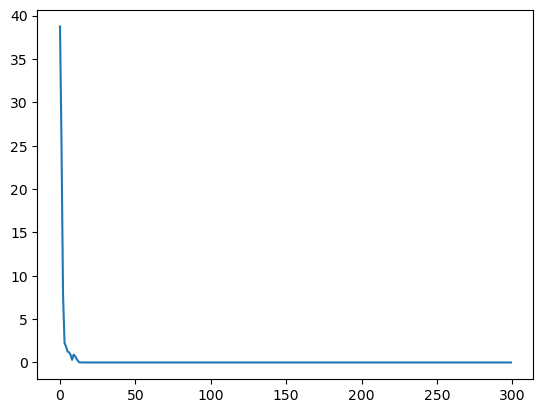

In [443]:
# Training loop
epochs = 300

for epoch in range(epochs):
    total_loss = 0
    for i, (X, y) in enumerate(data_loader):
        inputs, labels = X, y

        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    history.append(total_loss)
    if (not ((epoch) % 10)):
        print(f"Epoch: {epoch} Loss: {total_loss}")

plt.plot(history)

# Validation

In [444]:
# Validation
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = torch.sum(predicted == Y_test).item() / len(Y_test)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 91.67%


tensor([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
         4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
         9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
        13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
        18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22,
        22, 22, 23, 23, 23, 23]) tensor([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  1,  4,  4,
         2,  4,  5,  5, 13,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
         9,  9,  9, 21, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
        13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17,  0, 17,
        18, 18, 18, 18, 19, 19, 19, 19, 20, 14, 20, 20,  9, 21, 21, 21, 12, 22,
        22, 22, 23, 23, 23, 23])


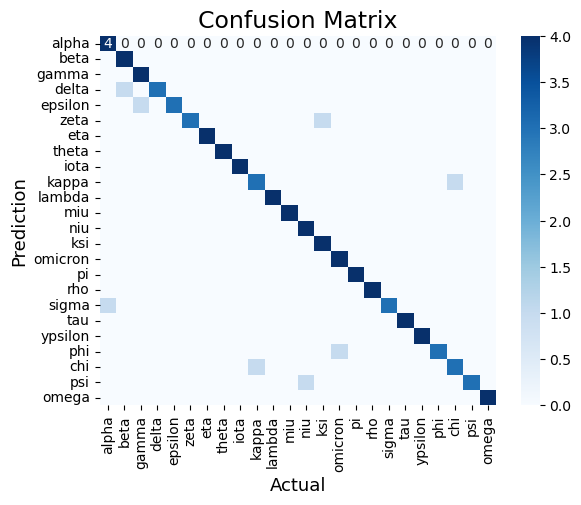

In [445]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

alphabet=['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta'
          , 'eta', 'theta', 'iota', 'kappa', 'lambda', 'miu', 'niu'
          , 'ksi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'ypsilon'
          , 'phi', 'chi', 'psi', 'omega']

with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    predictions = torch.argmax(outputs, dim=1)

print(Y_test, predictions)
conf_mat = confusion_matrix(Y_test, predictions)

# Set the labels explicitly for the confusion matrix
conf_mat_df = pd.DataFrame(conf_mat, index=alphabet, columns=alphabet)

sns.heatmap(conf_mat, 
            annot=True,
            fmt = 'd',
            cmap="Blues",
            xticklabels=alphabet,
            yticklabels=alphabet,)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# Save model

In [440]:
model_path = 'best_model.pth'
torch.save(model, model_path)